# 6. 두 개 층 연결

### 6.1 신경망 알고리즘 벡터화

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [4]:
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y,
                                                            test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all,
                                                  test_size = 0.2, random_state=42)


In [5]:
print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [6]:
class SingleLayer:

    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None      # 가중치
        self.b = None      # 절편
        self.losses = []   # 훈련 손실
        self.val_losses = []  # 검증 손실
        self.w_history = []   # 가중치 기록 
        self.lr = learning_rate  # 학습률
        self.l1 = l1    # L1 손실 하이퍼파라미터
        self.l2 = l2    # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z = np.dot(x, self.w) + self.b   # 선형 출력 계산
        return z
    
    def backprop(self, x, err):
        m = len(x)
        w_grad = np.dot(x.T, err) / m   # 가중치 그래디언트 계산
        b_grad = np.sum(err) / m        # 절편 그래디언트 계산
        return w_grad, b_grad
    
    def activation(self, z):
        z = np.clip(z, -100, None)      # 안전한 np.exp() 계산
        a = 1 / (1 + np.exp(-z))        # 시그모이드 계산
        return a
    
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)            # 타깃을 열 벡터로 바꿈
        y_val = y_val.reshape(-1, 1)
        m = len(x)                      # 샘플 개수를 저장
        self.w = np.ones((x.shape[1], 1))  # 가중치 초기화
        self.b = 0                        # 절편 초기화
        self.w_history.append(self.w.copy())  # 가중치 기록

        for i in range(epochs):
            z = self.forpass(x)            # 정방향 계산 수행
            a = self.activation(z)         # 활성화 함수 적용
            err = -(y - a)                 # 오차 계산
            w_grad, b_grad = self.backprop(x, err)  # 오차 역전파 그래디언트 계산
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m  # 그래디언트에 대한 패널티 항 미분값 더함
            self.w -= self.lr * w_grad      # 그래디언트에 패널티 항 미분값 더함
            self.b -= self.lr * b_grad      # 가중치 절편 업데이트
            self.w_history.append(self.w.copy())   # 가중치 기록
            a = np.clip(a, 1e-10, 1-1e-10)   # 안전한 로그 계산 클리핑
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))  # 로그 손실과 규제 손실 더하여 리스트 추가
            self.losses.append((loss + self.reg_loss()) / m)   
            self.update_val_loss(x_val, y_val)  # 검증 세트에 대한 손실 계산


    def predict(self, x):
        z = self.forpass(x)    # 정방향 계산 수행
        return z > 0          # 스텝 함수 적용
        
    def score(self, x, y):
            # 예측과 타깃 열 벡터를 비교하여 True의 비율 반환
        return np.mean(self.predict(x) == y.reshape(-1, 1))
        
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w) + self.l2 / 2 * np.sum(self.w**2))  # 가중치 규제 적용
        
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)   # 정방향 계산 수행
        a = self.activation(z)    # 활성화 함수 적용
        a = np.clip(a, 1e-10, 1-1e-10)   # 출력값 클리핑
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))   # 로그 손실과 규제 손실 더하여 리스트 추가
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))



In [7]:
from sklearn.preprocessing import StandardScaler

- StandardScaler

Scikit-Learn (또는 sklearn) 라이브러리에서 제공하는 데이터 전처리 도구 중 하나

데이터의 스케일을 조정하고 정규화하는 데 사용

StandardScaler는 주로 다음과 같은 단계로 사용됩니다

1. 데이터를 불러오거나 생성합니다.
2. StandardScaler 객체를 생성합니다.
3. fit 메서드를 사용하여 StandardScaler를 데이터에 맞춥니다. 이렇게 하면 각 특성의 평균과 표준 편차를 계산합니다.
4. transform 메서드를 사용하여 데이터를 실제로 스케일링합니다. 이렇게 하면 각 특성의 값을 평균이 0이고 표준 편차가 1인 분포로 변환

In [8]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [9]:
single_layer = SingleLayer(l2 = 0.01)
single_layer.fit(x_train_scaled, y_train,
                 x_val=x_val_scaled, y_val=y_val, epochs=10000)
single_layer.score(x_val_scaled, y_val)


0.978021978021978

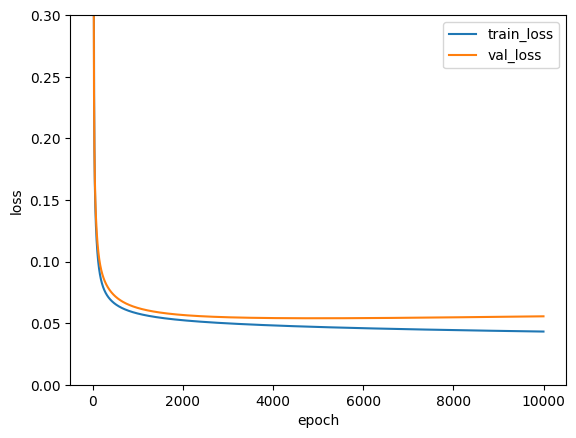

In [10]:
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

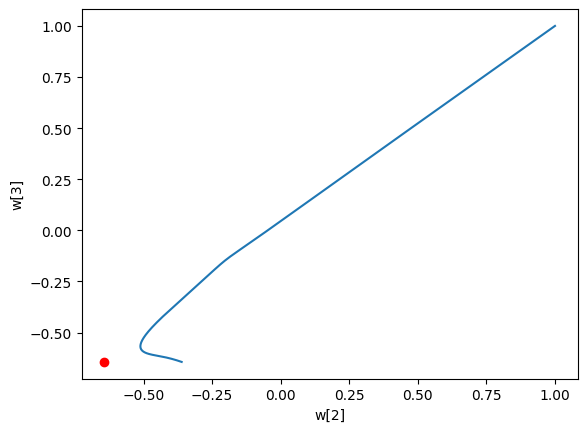

In [28]:
w2 = []
w3 = []
for w in single_layer.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w3[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

### 6.2 2개의 층 연결

In [23]:
class DualLayer(SingleLayer):
    
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.activation(z1)            # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad

    def init_weights(self, n_features):
        self.w1 = np.ones((n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)               # 은닉층의 크기
        self.w2 = np.ones((self.units, 1))           # (은닉층의 크기, 1)
        self.b2 = 0
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)          # 타깃을 열 벡터로 바꿉니다.
        y_val = y_val.reshape(-1, 1)
        m = len(x)                    # 샘플 개수를 저장합니다.
        self.init_weights(x.shape[1]) # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            a = self.training(x, y, m)
            # 안전한 로그 계산을 위해 클리핑합니다.
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)
            
    def training(self, x, y, m):
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.activation(z)    # 활성화 함수를 적용합니다.
        err = -(y - a)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에 페널티 항의 미분 값을 더합니다
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
    
    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

In [24]:
dual_layer = DualLayer(l2=0.01)
dual_layer.fit(x_train_scaled, y_train,
               x_val=x_val_scaled, y_val=y_val, epochs=20000)
dual_layer.score(x_val_scaled, y_val)

0.978021978021978

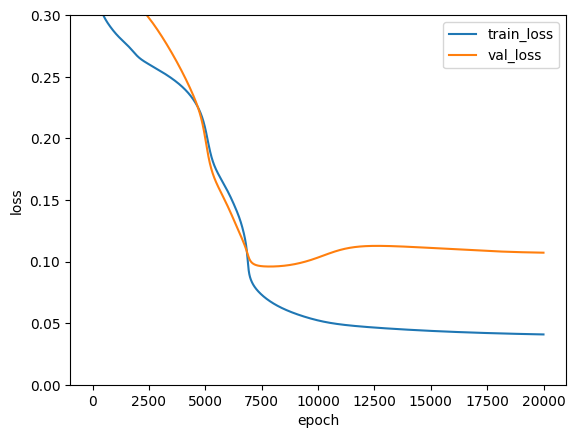

In [25]:
# y축 범위를 0에서 0.3으로 설정합니다.
plt.ylim(0, 0.3)

# 학습 손실(train_loss)을 그래프로 표시합니다.
plt.plot(dual_layer.losses)

# 검증 손실(val_loss)을 그래프로 표시합니다.
plt.plot(dual_layer.val_losses)

# y축에 레이블을 추가합니다.
plt.ylabel('loss')

# x축에 레이블을 추가합니다.
plt.xlabel('epoch')

# 그래프에 범례를 추가합니다.
plt.legend(['train_loss', 'val_loss'])

In [21]:
class RandomlnotNetwork(DualLayer):

    def init_weights(self, n_festures):
        np.random.seed(42)
        self.w1 = np.random.normal(0, 1,
                                   (n_festures, self.units))    # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                          # 은닉층의 크기
        self.w2 = np.random.normal(0, 1,
                                   (self.units, 1))             # (은닉층의 크기, 1)
        self.v2 = 0

### 여기부터 오류뜬 이유를 몰라서 일단 복붙만 진행

In [26]:
randon_init_net = RandomlnotNetwork(l2=0.01)
randon_init_net.fit(x_train_scaled, y_train,
                    x_val=x_val_scaled, y_val=y_val, epochs=500)

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

In [27]:
plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

NameError: name 'random_init_net' is not defined

### 6-3 미니배치 

In [ ]:
class MinibatchNetwork(RandomInitNetwork):
    
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        super().__init__(units, learning_rate, l1, l2)
        self.batch_size = batch_size     # 배치 크기
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y_val = y_val.reshape(-1, 1)     # 타깃을 열 벡터로 바꿉니다.
        self.init_weights(x.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        np.random.seed(42)
        # epochs만큼 반복합니다.
        for i in range(epochs):
            loss = 0
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            for x_batch, y_batch in self.gen_batch(x, y):
                y_batch = y_batch.reshape(-1, 1) # 타깃을 열 벡터로 바꿉니다.
                m = len(x_batch)                 # 샘플 개수를 저장합니다.
                a = self.training(x_batch, y_batch, m)
                # 안전한 로그 계산을 위해 클리핑합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / len(x))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.

In [ ]:
minibatch_net = MinibatchNetwork(l2=0.01, batch_size=32)
minibatch_net.fit(x_train_scaled, y_train, 
                  x_val=x_val_scaled, y_val=y_val, epochs=500)
minibatch_net.score(x_val_scaled, y_val)

In [ ]:
plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
minibatch_net = MinibatchNetwork(l2=0.01, batch_size=128)
minibatch_net.fit(x_train_scaled, y_train, 
                  x_val=x_val_scaled, y_val=y_val, epochs=500)
minibatch_net.score(x_val_scaled, y_val)

In [ ]:
plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, ), activation='logistic',
                    solver='sgd', alpha=0.01, batch_size=32,
                    learning_rate_init=0.1, max_iter=1000)
mlp.fit(x_train_scaled, y_train)
mlp.score(x_val_scaled, y_val)